   Index    Asset1    Asset2    Asset3    Asset4
0      0  0.012495  0.011126  0.003252  0.006625
1      1  0.011439  0.002691  0.001206  0.006947
2      2  0.000632  0.007277  0.004049  0.000074
3      3  0.017828  0.028210  0.007758  0.007382
4      4  0.021115  0.019642  0.009238  0.011499
           Index      Asset1      Asset2      Asset3      Asset4
count  746.00000  746.000000  746.000000  746.000000  746.000000
mean   372.50000    0.013144    0.012822    0.009366    0.010788
std    215.49594    0.011914    0.011712    0.009283    0.009338
min      0.00000    0.000012    0.000057    0.000014    0.000067
25%    186.25000    0.004761    0.003878    0.003202    0.004226
50%    372.50000    0.010030    0.009423    0.006641    0.008508
75%    558.75000    0.017771    0.017810    0.012354    0.014221
max    745.00000    0.098709    0.088502    0.072016    0.074291


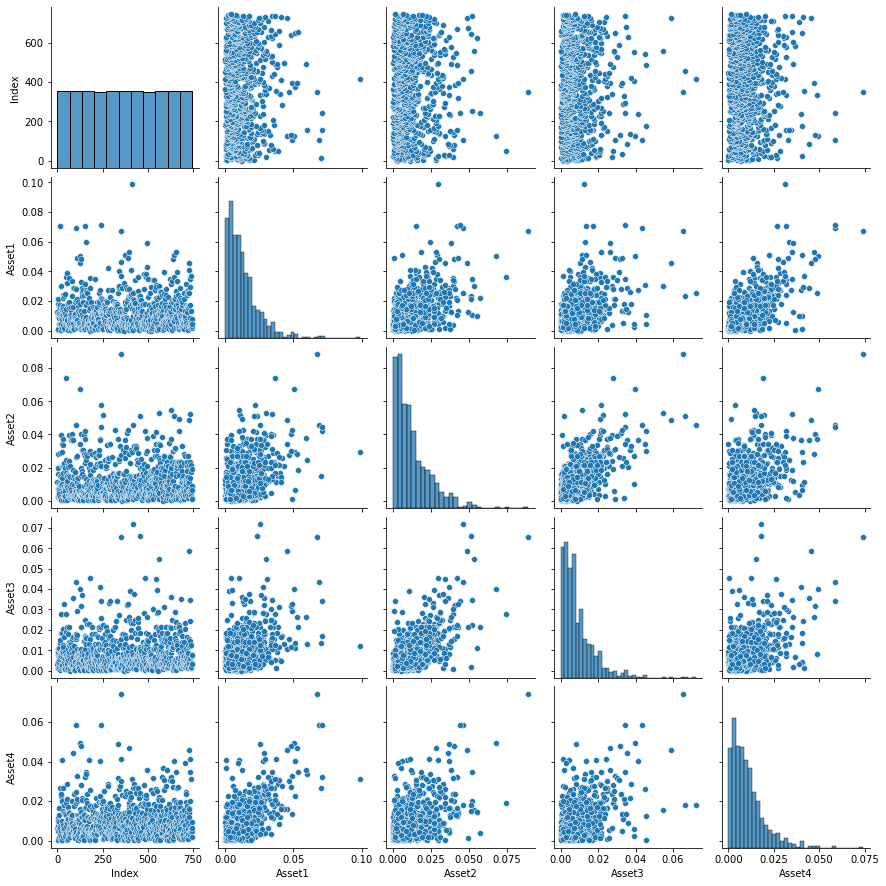

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "data_train_log_return.csv"
df = pd.read_csv(file_path, header=None, names=["Index", "Asset1", "Asset2", "Asset3", "Asset4"])

# Display the first few rows of the dataframe
print(df.head())

# Basic statistics of the dataset
print(df.describe())

# Pairplot for initial visualization
sns.pairplot(df)
plt.show()

In [88]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split

# Split the dataset
train_data, test_data = train_test_split(df[["Asset1", "Asset2", "Asset3", "Asset4"]], test_size=0.2, random_state=42)

# Convert to PyTorch tensors
train_data = torch.tensor(train_data.values, dtype=torch.float32)
test_data = torch.tensor(test_data.values, dtype=torch.float32)

# Updated Generator
class Generator(nn.Module):
    def __init__(self, input_size, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # nn.Linear(input_size, 128),
            # nn.ReLU(),
            # nn.Linear(128, 128),
            # nn.ReLU(),
            # nn.Linear(128, 256),
            # nn.ReLU(),
            # nn.Linear(256, output_size),
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Linear(10, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Updated Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # nn.Linear(input_size, 256),
            # nn.ReLU(),
            # nn.Linear(256, 128),
            # nn.ReLU(),
            # nn.Linear(128, 1),
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_size = 100  # Size of random noise vector for the generator
output_size = 4   # Number of features in your dataset

# Create instances of the generator and discriminator
generator = Generator(input_size, output_size)
discriminator = Discriminator(output_size)

# Define loss function and optimizers
criterion = nn.BCELoss()
gen_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
disc_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

In [106]:
# Training loop
num_epochs = 3000
batch_size = 64
desired_mean = torch.mean(test_data[:, 0])
desired_var = torch.var(test_data[:, 0])
loss_increase_threshold = 0.05  # Adjust as needed
# Initialize previous losses
prev_disc_loss = float('inf')
prev_gen_loss = float('inf')


for epoch in range(num_epochs):
    # ---------------------
    # Train Discriminator
    # ---------------------

    # Sample real data
    indices = torch.randint(0, len(train_data), (batch_size,))
    real_data = train_data[indices]
    
    
    # Generate fake data again
    # noise = torch.randn(batch_size, input_size) * desired_var**0.5 + desired_mean  # Ensure input_size matches the generator input size
    noise = torch.randn(batch_size, input_size)  # Ensure input_size matches the generator input size
    fake_data = generator(noise)
    
    

    # Labels for real and fake data
    real_labels = torch.ones((batch_size, 1))
    fake_labels = torch.zeros((batch_size, 1))

    # Train the discriminator
    disc_optimizer.zero_grad()
    real_pred = discriminator(real_data)
    fake_pred = discriminator(fake_data.detach())
    real_loss = criterion(real_pred, real_labels)
    fake_loss = criterion(fake_pred, fake_labels)
    total_disc_loss = real_loss + fake_loss
    total_disc_loss.backward()
    disc_optimizer.step()

    # ---------------------
    # Train Generator
    # ---------------------

    # Generate fake data again
    # noise = torch.randn(batch_size, input_size) * desired_var**0.5 + desired_mean
    noise = torch.randn(batch_size, input_size)
    fake_data = generator(noise)

    # Train the generator
    gen_optimizer.zero_grad()
    gen_pred = discriminator(fake_data)
    gen_loss = criterion(gen_pred, real_labels)  # Generator wants to fool the discriminator
    gen_loss.backward()
    gen_optimizer.step()
    
    
    # Calculate the change in losses
    delta_disc_loss = total_disc_loss.item() - prev_disc_loss
    delta_gen_loss = gen_loss.item() - prev_gen_loss

    # Update the previous losses for the next iteration
    prev_disc_loss = total_disc_loss.item()
    prev_gen_loss = gen_loss.item()
    # Check if the losses are increasing beyond the threshold
    if delta_disc_loss > loss_increase_threshold or delta_gen_loss > loss_increase_threshold:
        print(f"Losses are increasing. Stopping training.")
        break

    # Print training stats
    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Disc Loss: {total_disc_loss.item()}, Gen Loss: {gen_loss.item()}")

# Training complete
print("GAN training completed!")


Epoch [0/3000], Disc Loss: 1.3870373964309692, Gen Loss: 0.6929365992546082
Epoch [50/3000], Disc Loss: 1.3865728378295898, Gen Loss: 0.6931232810020447
Epoch [100/3000], Disc Loss: 1.3858773708343506, Gen Loss: 0.6929744482040405
Epoch [150/3000], Disc Loss: 1.385019063949585, Gen Loss: 0.693183958530426
Epoch [200/3000], Disc Loss: 1.3851252794265747, Gen Loss: 0.6936770677566528
Epoch [250/3000], Disc Loss: 1.384671926498413, Gen Loss: 0.6936824917793274
Epoch [300/3000], Disc Loss: 1.3847815990447998, Gen Loss: 0.6935266852378845
Epoch [350/3000], Disc Loss: 1.3841885328292847, Gen Loss: 0.6936792135238647
Epoch [400/3000], Disc Loss: 1.3844882249832153, Gen Loss: 0.6938269734382629
Epoch [450/3000], Disc Loss: 1.384129524230957, Gen Loss: 0.6942107677459717
Epoch [500/3000], Disc Loss: 1.3842151165008545, Gen Loss: 0.6941013336181641
Epoch [550/3000], Disc Loss: 1.3850805759429932, Gen Loss: 0.6940277218818665
Epoch [600/3000], Disc Loss: 1.3848681449890137, Gen Loss: 0.6942054033

In [107]:
# Set the generator in evaluation mode
generator.eval()

# Generate new samples
num_samples = len(test_data) # Adjust as needed
desired_mean = torch.mean(test_data[:, 0])
desired_var = torch.var(test_data[:, 0])
#Change the noise 
# noise_for_generation = torch.randn(num_samples, input_size) * desired_var**0.5 + desired_mean 
noise_for_generation = torch.randn(num_samples, input_size)

# # Set the desired mean for the exponential distribution
# # Calculate the rate parameter (lambda) from the desired mean
# rate_parameter = 1.0 / desired_mean
# # exp_noise = torch.empty(num_samples, 1).exponential_(rate_parameter)
# # noise_for_generation = torch.cat([exp_noise, torch.randn(num_samples, input_size - 1)], dim=1)
# exp_noise = torch.empty(num_samples, input_size).exponential_(rate_parameter)
# noise_for_generation = exp_noise

generated_samples = generator(noise_for_generation)

# Convert to a Pandas DataFrame for easy inspection
generated_df = pd.DataFrame(generated_samples.detach().numpy(), columns=["Asset1", "Asset2", "Asset3", "Asset4"])

# Display the generated samples
print("Generated Samples:")
print(generated_df)

Generated Samples:
       Asset1    Asset2    Asset3    Asset4
0    0.000871  0.017509  0.000827  0.002728
1    0.008068  0.013870  0.010335  0.006418
2    0.007282  0.034749  0.012508  0.011557
3    0.005022  0.019442  0.004439  0.005758
4    0.003769  0.009074  0.001442  0.006728
..        ...       ...       ...       ...
145  0.014042  0.013148  0.005364  0.021361
146  0.003074  0.008484  0.001852  0.008283
147  0.011360  0.031748  0.016538  0.023292
148  0.022542  0.051064  0.009091  0.008106
149  0.005516  0.018239  0.007727  0.004488

[150 rows x 4 columns]


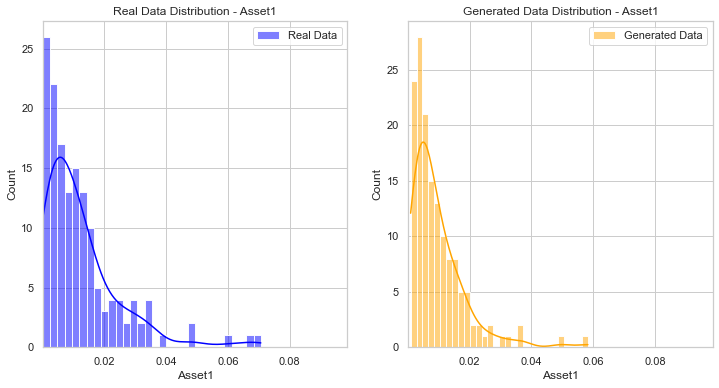

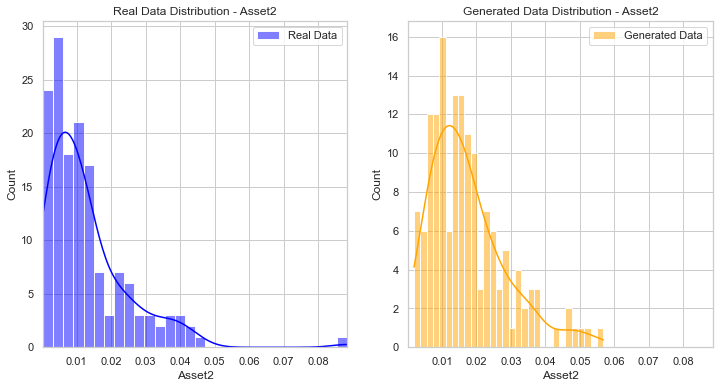

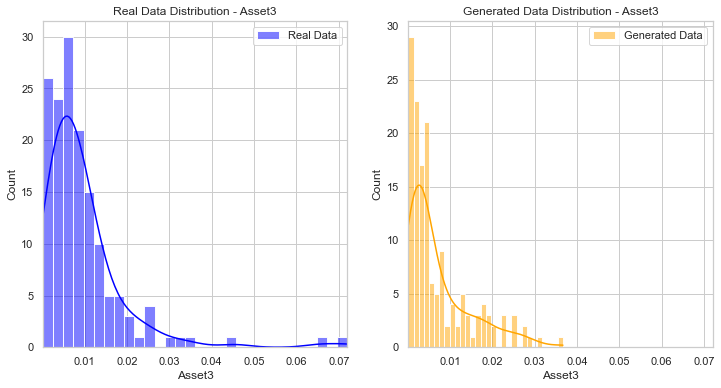

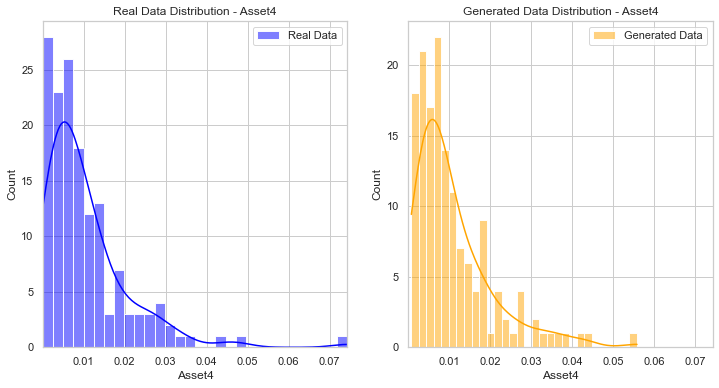

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visuals
sns.set(style="whitegrid")

plot_test_data = pd.DataFrame(test_data.detach().numpy(), columns=["Asset1", "Asset2", "Asset3", "Asset4"])

# Plotting real vs generated distributions for each feature
for i, feature in enumerate(["Asset1", "Asset2", "Asset3", "Asset4"]):
    plt.figure(figsize=(12, 6))

    # Plot real data distribution
    plt.subplot(1, 2, 1)
    sns.histplot(plot_test_data[feature], bins=30, kde=True, color='blue', label='Real Data')
    plt.title(f"Real Data Distribution - {feature}")
    plt.legend()
    plt.xlim(plot_test_data[feature].min(), df[feature].max())

    # Plot generated data distribution
    plt.subplot(1, 2, 2)
    sns.histplot(generated_df[feature], bins=30, kde=True, color='orange', label='Generated Data')
    plt.title(f"Generated Data Distribution - {feature}")
    plt.legend()
    plt.xlim(plot_test_data[feature].min(), df[feature].max())

    plt.show()


In [109]:
generated_df

,Asset1,Asset2,Asset3,Asset4
0,0.000871,0.017509,0.000827,0.002728
1,0.008068,0.013870,0.010335,0.006418
2,0.007282,0.034749,0.012508,0.011557
3,0.005022,0.019442,0.004439,0.005758
4,0.003769,0.009074,0.001442,0.006728
...,...,...,...,...
145,0.014042,0.013148,0.005364,0.021361
146,0.003074,0.008484,0.001852,0.008283
147,0.011360,0.031748,0.016538,0.023292
148,0.022542,0.051064,0.009091,0.008106


In [110]:
plot_test_data

,Asset1,Asset2,Asset3,Asset4
0,0.034773,0.028652,0.013291,0.011468
1,0.008981,0.002516,0.013169,0.001429
2,0.011846,0.006954,0.003037,0.003917
3,0.004184,0.039562,0.000638,0.013664
4,0.023731,0.003503,0.002841,0.015834
...,...,...,...,...
145,0.002452,0.013193,0.008896,0.008478
146,0.008109,0.003980,0.002775,0.003246
147,0.010342,0.012447,0.002132,0.006324
148,0.032812,0.019456,0.021594,0.028103
